# Introduction

There are several ways to look up a value in a dictionary in Python. 

In [1]:
dictionary = {'known': 'value'}

The most obvious way is straight indexing:

In [2]:
key = 'known'
value = dictionary[key]

But what if we don't know if the dictionary contains the key, and we'd like to get a default value if it isn't? 

In [3]:
key = 'unknown'
# value = dictionary[key]   # will cause an error

So, we could do this

In [4]:
if key in dictionary:
    value = dictionary[key]
else:
    value = 'default'

But dictionaries also have a `.get()` method which does basically the same thing. It will return `default` if the dictionary doesn't contain the key. If `default` is not supplied, `dictionary.get(key)` returns `None`.

In [5]:
dictionary.get('known', 'default')

'value'

In [6]:
dictionary.get('unknown', 'default')

'default'

In [7]:
dictionary.get('unknown') is None

True

I have spotted a pattern where people start using `.get()` all the time, instead of ever indexing. I think this might be because they feel it's "safer" – it will never raise an exception. But once you start getting into that habit you forget about using `in` to check if a key is in a dictionary and you start to do things like this:

In [8]:
def get_default(dictionary, key):
    value = dictionary.get(key)
    if value is not None:  # effectively check if key was in dictionary
        return value

*Note* You might also check using `if value`, but this will not work the way you expect if the actual value you're looking for is falsey (like [] or 0), see for example [this video](https://youtu.be/qiZyDLEJHh0?t=792) where a pytest slowdown was caused by this exact problem. I've linked to the time where that code is on the screen.

I commented on that video about using the `in` pattern instead and Anthony replied *"using `in` is a common performance mistake -- it forces you to use two lookups to retrieve the value rather than just one"*

This is pretty clear if you compare the code - you're doing all the hashing and lookup just once with `.get()` but with the `in` check you might need to do it twice:

In [9]:
def in_then_index(dictionary, key):
    if key in dictionary:   # first lookup
        return dictionary[key]   # second possible lookup

# Basic benchmarking

So, I did a quick benchmark. Remember

In [10]:
dictionary

{'known': 'value'}

In [11]:
%%timeit
get_default(dictionary, "known")

119 ns ± 2.14 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [12]:
%%timeit
get_default(dictionary, "unknown")

117 ns ± 4.91 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [13]:
%%timeit
in_then_index(dictionary, "known")

96.7 ns ± 2.08 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [14]:
%%timeit
in_then_index(dictionary, "unknown")

82.9 ns ± 1.61 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


I mentioned in the video comments that my benchmarks didn't show `get` to be faster. Anthony doubted the validity of my benchmaks:

<blockquote>
     I suspect your benchmarking is incorrect.  also for caches the hot case is going to be hits (you tend to optimize for success rather than failure).  I also suspect you're not considering fill size or collision rate in your benchmark.  there is a third approach which is even faster via `try: ... except KeyError: ...` which I usually choose
</blockquote>

I think he's talking about this as a pattern

In [15]:
def try_index_except(dictionary, key):
    try:
        return dictionary[key]
    except KeyError:
        pass  # or return default

In [16]:
%%timeit
try_index_except(dictionary, "known")

83.6 ns ± 1.48 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [17]:
%%timeit
try_index_except(dictionary, "unknown")

210 ns ± 3.72 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


It's worth remembering that there is some overhead associated with calling a function in the first place, even if you just return

In [18]:
def function_call(dictionary, key):
    return

In [19]:
%%timeit
function_call(dictionary, "known")

70.5 ns ± 1.48 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Basic benchmark plotted

Let's see what that looks like on a chart, where we can view the trade-offs of a known key vs an unknown key with the function call overhead:

In [20]:
import sys
import timeit
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
print(sys.version)

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]


In [22]:
loops = 1_000_000
repeats = 20

In [23]:
methods = ["get_default", "in_then_index", "try_index_except", "function_call"]

We'll look up these keys, which have 100% or 0% chance to be in the dictionary

In [24]:
import tqdm
from tqdm.auto import tqdm

In [25]:
def bench(dictionary, lookups):
    results = []
    progress = tqdm(total=len(methods)*len(lookups))
    localglobals = globals()
    for method in methods:
        for key, chance in lookups:
            # This weird pre-evaluation is needed for later
            localglobals.update({'dictionary': dictionary, 'key': eval(f"{key!r}")})
            times =timeit.repeat(
                f'{method}(dictionary, key)', 
                globals=localglobals,
                repeat=repeats, 
                number=loops,
            )

            results.append({
                'method': method,
                'chance': chance,
                'time': min(times)
            })
            progress.update(1)

    return pd.DataFrame(results)

In [26]:
df_string = bench(
    dictionary={'known': 1}, 
    lookups = (("known", 1), ("unknown", 0))
)

100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


In [27]:
def plot(df, ax):
    (
        df.set_index(["chance", "method"])
        .unstack("method")
        ["time"]
        .plot(
            ax=ax,
            xlabel="Chance of key being in dictionary",
            ylabel="Time / µs",
        )
    )
    ax.set_ylim(bottom=0)

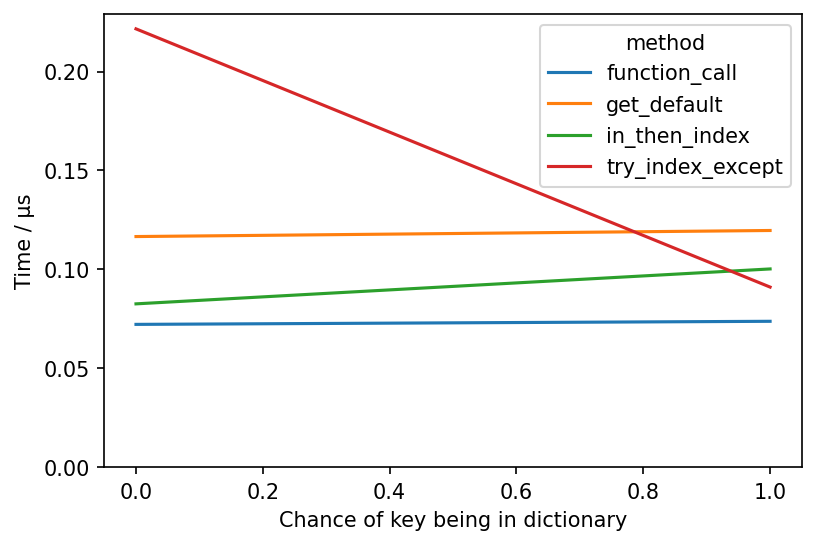

In [28]:
fig, ax = plt.subplots(dpi=150)
plot(df_string, ax)

We see that just doing `key in dictionary` (at the 0 chance part of `in_then_index`) is not that much slower than calling a function and returning. Let's see what the timings look like with that function call overhead subtracted. I'd also like to insulate these results from differences on machines, so I'm going to normalise by that function call overhead.

In [29]:
time_function_call = df_string.query('method == "function_call"')['time'].mean()

In [30]:
def normalize(df):
    result = df.copy()
    result['ratio'] = (df['time'] - time_function_call)/time_function_call
    
    return result.query('method != "function_call"')

In [48]:
def plot_ratio(df, ax, order=None):
    normalized = (
        normalize(df).set_index(["chance", "method"])
        .unstack("method")
        ["ratio"]
    )
    if order is not None:
        normalized = normalized[[c for c in order if c in normalized.columns]]
    (
        normalized
        .plot(
            ax=ax,
            xlabel="Chance of key being in dictionary",
            ylabel="extra time / function call time",
        )
    )
    ax.set_ylim(bottom=0)

In [32]:
normalized_small_string = normalize(df_string)

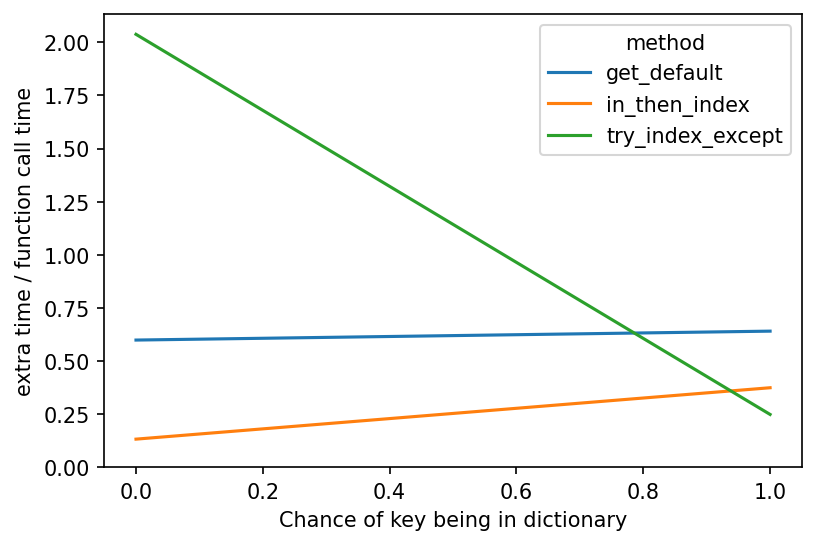

In [33]:
fig, ax = plt.subplots(dpi=150)
plot_ratio(df_string, ax)

From these simple results it seems like we can make the following preliminary observations:

1. `get` is never faster than `in` followed by indexing, even when you do both `in` and indexing.
2. The cost of raising an exception is so high that you've got to be very sure that the key is almost always (more than 90%) in the dictionary, but if you are it is the fastest to try to index and then handle the exception if the key is not found.

I will admit that testing this on a dictionary containing only one key is not the best benchmark. There probably aren't key collisions here and we're not checking for fill rate.

Also, Python has a special case fast path for dictionaries which have only string keys (see [here](https://wiki.python.org/moin/TimeComplexity)), so we expect string dictionaries to be faster than heterogenous ones, and both of those to be faster if the keys are built-in objects than if they are custom objects. See also [this stackoverflow question] about slow lookups for custom objects.

## Non-string dictionary keys

So, let's try some other kinds of keys

Here is a small dictionary with integer keys. We know Python uses a super fast method for hashing ints - they just hash to themselves, so we expect this to be pretty quick too.

In [34]:
known = 1
unknown = 0
df_int = bench(
    dictionary={known: 1},
    lookups=((known, 1), (unknown, 0))
)

100%|██████████| 8/8 [00:19<00:00,  2.47s/it]


Lastly, let's try to create a new hashable class. To make a class hashable, you need to implement `__hash__` and `__eq__`. I'm implementing `__repr__` as well so that the bench code works correctly. 

In [35]:
class CustomHashable:
    def __init__(self, v):
        self.v = v
    def __hash__(self):
        return hash(self.v)
    def __eq__(self, other):
        return self.v == other.v
    def __repr__(self):
        return f"CustomHashable({self.v!r})"

In [36]:
known = CustomHashable('known')
unknown = CustomHashable('unknown')

df_cust = bench(
    dictionary={known: 1},
    lookups=((known, 1), (unknown, 0)),
)

100%|██████████| 8/8 [00:42<00:00,  5.25s/it]


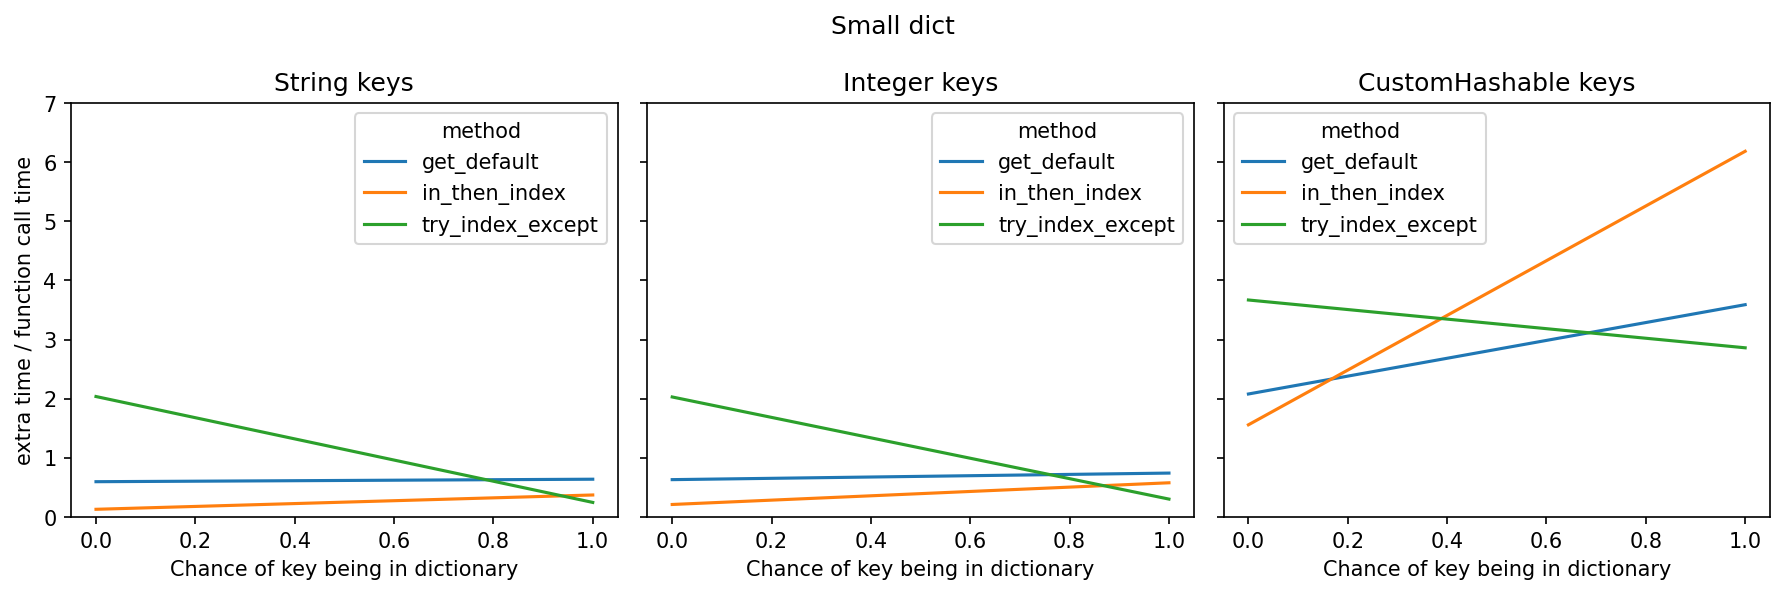

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), dpi=150, sharey=True)
plot_ratio(df_string, ax1)
ax1.set_title('String keys')
plot_ratio(df_int, ax2)
ax2.set_title('Integer keys')
plot_ratio(df_cust, ax3)
ax3.set_title('CustomHashable keys')
ax3.set_ylim(top=7)
plt.suptitle('Small dict')
plt.tight_layout()

So we have found a place where `get` is better! We're clearly paying the cost of calculating that hash twice in the `in_then_index` method.

## Defaultdict

I've recieved questions of how `defaultdict` stacks up against the other methods. I'm not going to do a full benchmark, since I think it covers a slightly different use case, but let's add that graph, too:

In [38]:
from collections import defaultdict

In [39]:
def only_index(dictionary, key):
    return dictionary[key]

In [40]:
methods.append('only_index')

In [41]:
defdict = defaultdict(int)
defdict['known'] = 1
df_string_default = bench(
    dictionary=defdict,
    lookups=(('known', 1), ('unknown', 0)),
)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Text(0.5, 1.0, 'defaultdict with string keys')

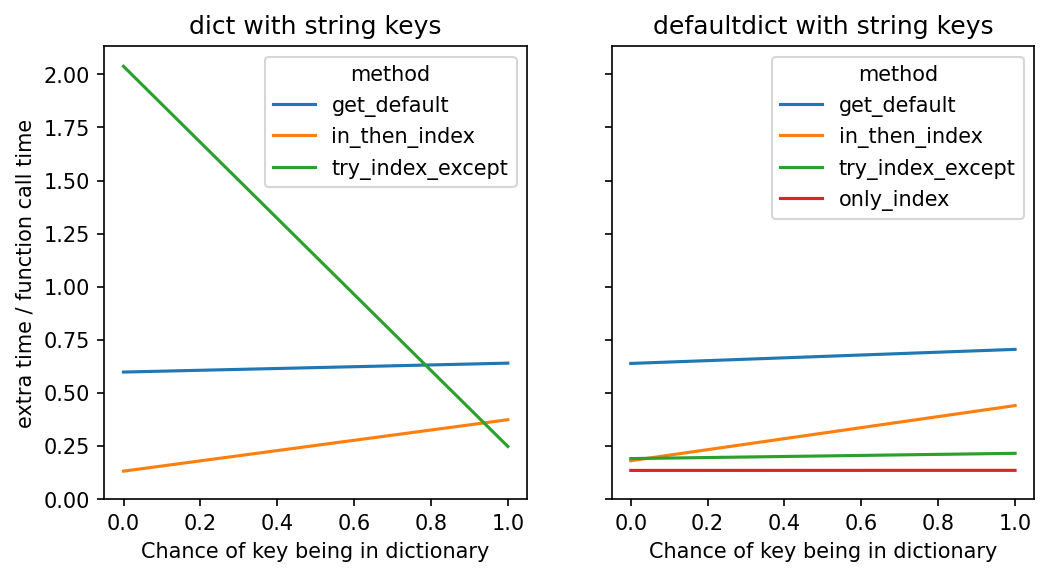

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True)
plot_ratio(df_string, ax1)
ax1.set_title('dict with string keys')
plot_ratio(df_string_default, ax2, order=methods)
ax2.set_title('defaultdict with string keys')

In [42]:
known = 1
unknown = 0

defdict = defaultdict(int)
defdict[known] = 1
df_int_default = bench(
    dictionary=defdict,
    lookups=((known, 1), (unknown, 0)),
)

100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


In [43]:
known = CustomHashable('known')
unknown = CustomHashable('unknown')

defdict = defaultdict(int)
defdict[known] = 1

df_cust_default = bench(
    dictionary=defdict,
    lookups=((known, 1), (unknown, 0)),
)

100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


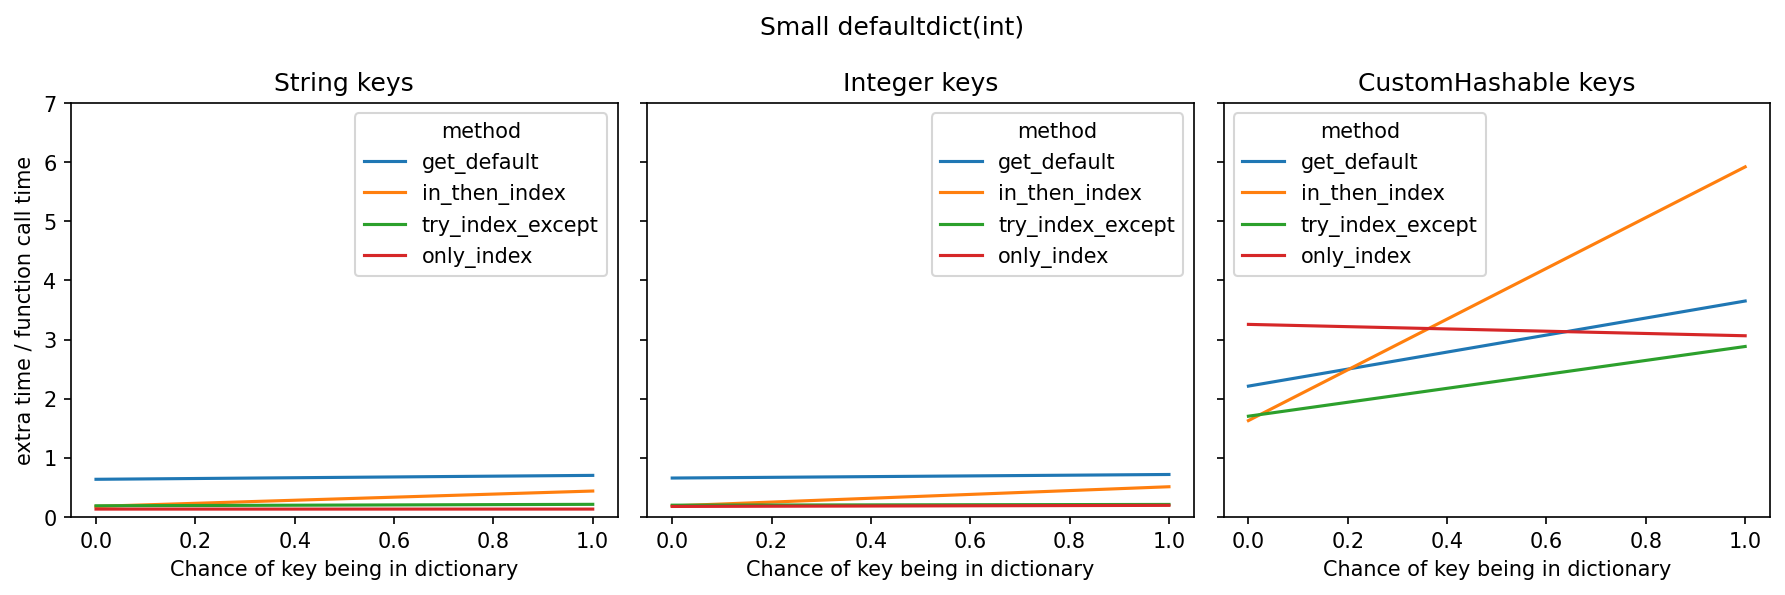

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4), dpi=150, sharey=True)
plot_ratio(df_string_default, ax1, methods)
ax1.set_title('String keys')
plot_ratio(df_int_default, ax2, methods)
ax2.set_title('Integer keys')
plot_ratio(df_cust_default, ax3, methods)
ax3.set_title('CustomHashable keys')
ax3.set_ylim(top=7)
plt.suptitle('Small defaultdict(int)')
plt.tight_layout()

Well, I must say I wasn't expecting that. Looks like `defaultdict` performs much the same as the equivalent `dict` except being much faster to return a default value if the key doesn't exist. I think if you're often wanting to return a default value, it's clear you should be using `defaultdict`.

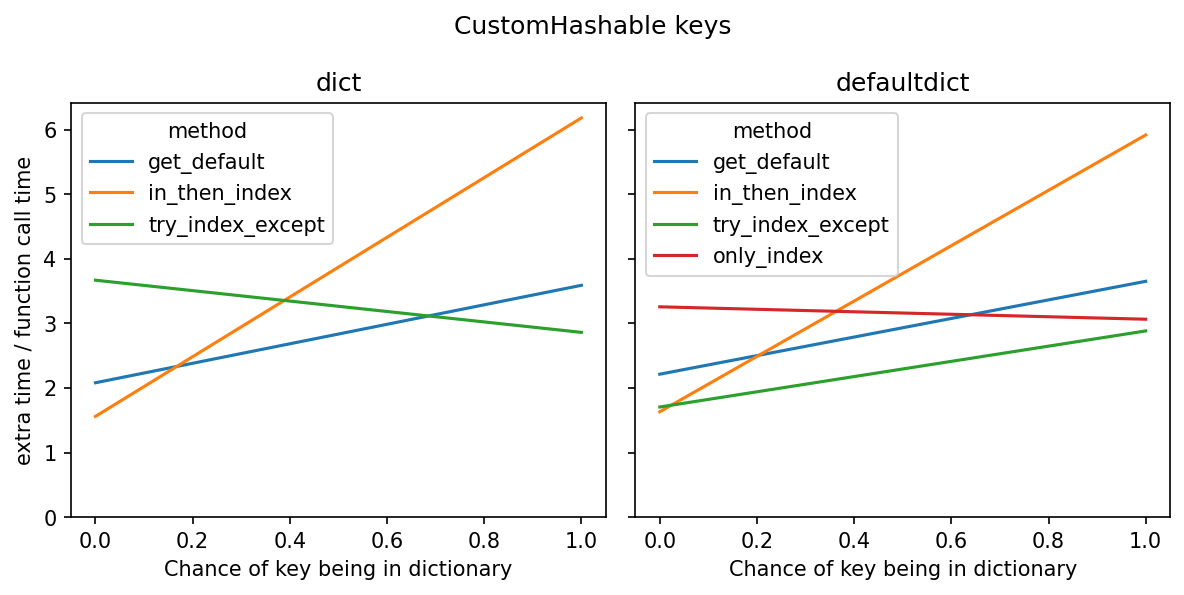

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), dpi=150, sharey=True)
plot_ratio(df_cust, ax1)
ax1.set_title('dict')
plot_ratio(df_cust_default, ax2, methods)
ax2.set_title('defaultdict')
plt.suptitle('CustomHashable keys')
plt.tight_layout()

This is the weirdest result so far! I have no idea why the indexing version is now slower than doing roughly the same thing inside a try

# Effect of dictionary size

In [39]:
import string
import random

In [40]:
def random_string(string_length):
    return ''.join(random.choices(string.ascii_lowercase, k=string_length))

In [41]:
def random_strings(number, string_length):
    strings = set()
    while len(strings) < number:
        strings.add(random_string(string_length))
    return list(strings)

In [42]:
dfs = []
for nkeys in [10, 1_000, 10_000, 1_000_000, 10_000_000, 30_000_000]:
    strings = random_strings(nkeys+1, 20)  # an extra one to be held back
    dictionary = dict.fromkeys(strings[:-1], None)
    known = strings[0]
    unknown = strings[-1]
    df = bench(
        dictionary=dictionary,
        lookups=((known, 1), (unknown, 0)),
    )
    df['dictionary_size'] = nkeys
    dfs.append(df)
df_size = pd.concat(dfs)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:01<?, ?it/s]

In [114]:
df_size['ratio'] = (df_size['time'] - time_function_call)/time_function_call

(0.0, 2.1138142044309087)

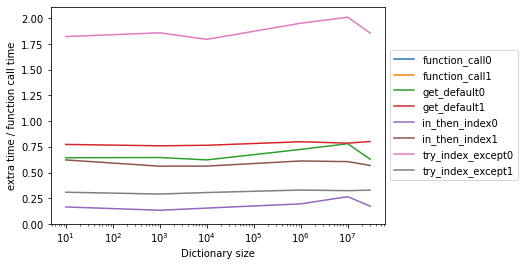

In [115]:
ax = (
    df_size
    .assign(name=df_size['method'] + df_size['chance'].astype(str))
    .set_index(['name', 'dictionary_size'])
    ['ratio']
    .unstack('name')
    .plot(logx=True)
)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Dictionary size')
ax.set_ylabel('extra time / function call time')
ax.set_ylim(bottom=0)

At least for string keys, none of the calls seem to be affected by the size of the dictionary in a way that changes the ordering of the times. Might become an issue at even larger sizes, but I don't often have 30 million-key dictionaries in my Python code.

# Deeper dive

Let's get a bit more sophisticated about the dictionary and the keys. We'll build a list of values to look up in a dictionary which has a given fraction of values that are in the dictionary. Note that we're using strings here. There may be differences in timings due to key collision chances.

In [17]:
def setup(dict_size, lookups, chance_of_dict_hit, string_length):
    dictionary = {random_string(string_length): 1 for _ in range(dict_size)}

    knowns = list(dictionary)

    n_known = int(lookups*chance_of_dict_hit)
    n_unknown = lookups - n_known
    lookup_list = random.choices(knowns, k=n_known)
    lookup_list += [random_string(string_length) for _ in range(n_unknown)]
    random.shuffle(lookup_list)
    
    return dictionary, lookup_list

I've played around with most of the parameters here, and mostly the results later on are dependent of the chance of a dictionary hit.

# Time all the things

I'm going to build a whole lot of different timing functions here. The basic setup is always the same - run through the lookup items and do some kind of operation. I'm doing more than one lookup in each function call to reduce the overhead of a function call on the timing.

I'm also timing a whole ton of stuff that looks strange and will be explained a bit later.

In [18]:
methods = []

In [62]:
def register_method(f):
    global methods
    methods.append(f.__name__)
    return f

In [63]:
@register_method
def function_call_pass(dictionary, lookup_list):
    pass

In [64]:
@register_method
def iterate_pass(dictionary, lookup_list):
    for l in lookup_list:
        pass

In [65]:
@register_method
def get_no_default(dictionary, lookup_list):
    for l in lookup_list:
        value = dictionary.get(l)

In [66]:
@register_method
def get_name_lookup(dictionary, lookup_list):
    for l in lookup_list:
        get = dictionary.get

In [67]:
@register_method
def get_cached(dictionary, lookup_list):
    get = dictionary.get
    for l in lookup_list:
        value = get(l)

In [68]:
@register_method
def if_only(dictionary, lookup_list):
    for l in lookup_list:
        if True:
            value = True
        else:
            value = None

In [69]:
@register_method
def in_then_index(dictionary, lookup_list):
    for l in lookup_list:
        if l in dictionary:
            value = dictionary[l]
        else:
            value = None

In [70]:
@register_method
def hash_only(dictionary, lookup_list):
    for l in lookup_list:
        hash(l)

In [71]:
@register_method
def in_only(dictionary, lookup_list):
    for l in lookup_list:
        l in dictionary

In [72]:
@register_method
def index_except(dictionary, lookup_list):
    for l in lookup_list:
        try:
            value = dictionary[l]
        except KeyError:
            value = None

In [73]:
@register_method
def raise_except(dictionary, lookup_list):
    for l in lookup_list:
        try:
            raise Exception()
        except:
            value = None

# Sweep chance of dictionary hit

You can imagine that if the dictionary always contains the key, the `in` + index method will be at its slowest due to the double lookup. Let's see how the chance of a hit affects timing.

In [74]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import sqlite3

In [75]:
loops = 10000
lookups = 1000
repeats = 10
dict_size = 1000
string_length = 30

In [76]:
db = sqlite3.connect('results.sqlite')

In [77]:
query = f"""
select method, chance, count(*) as c
from runs 
where 
    dict_size={dict_size}
    and loops={loops}
    and lookups={lookups}
    and string_length={string_length}
    and version='{sys.version}'
group by
    method, chance
"""
existing = pd.read_sql(query, db, index_col=['method', 'chance'])['c'].to_dict()

In [78]:
chances = np.linspace(0, 1, 51)

In [79]:
results = []

In [80]:
for chance in tqdm(chances):
    dictionary, lookup_list = setup(
        dict_size=dict_size,
        lookups=lookups,
        chance_of_dict_hit=chance,
        string_length=string_length,
    )
    for method in random.sample(methods, len(methods)):
        if existing.get((method, chance), 0) >= repeats:
            continue
            
        times = timeit.repeat(f'{method}(dictionary, lookup_list)', globals=globals(), repeat=repeats, number=loops)
        for time in times:
            results.append({
                'method': method,
                'dict_size' : dict_size,
                'lookups' : lookups,
                'string_length' : string_length,
                'chance': chance,
                'time': time,
                'loops': loops,
                'version': sys.version,
            })

  0%|          | 0/51 [00:00<?, ?it/s]

In [81]:
df = pd.DataFrame(results)

In [82]:
df.to_sql('runs', db, if_exists='append')

In [83]:
df = pd.read_sql('select * from runs', db, index_col='index')

We'll use the minimum value for every item as an indication of the best my machine can do on that operation. I'll also subtract function call overhead and divide by lookups.

In [130]:
mintimes = (
    df
    .groupby(['chance', 'method'])
    ['time']
    .min()
)

In [131]:
time_function_call = mintimes.groupby('method').mean()['function_call_pass']

In [137]:
minratios = (mintimes - time_function_call)/time_function_call/lookups

In [207]:
def plot_ratios(ratios, methods=None):
    if methods is None:
        methods = list(ratios.index.levels[1])
    ax = (
        ratios
        .loc[:, methods]
        .unstack()
        .plot(
            xlabel='Chance that key is in dictionary',
            ylabel='extra time/function call time',
            figsize=(10, 7),
        )
    )
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.set_ylim(bottom=0)
    
    return ax

<AxesSubplot:xlabel='Chance that key is in dictionary', ylabel='extra time/function call time'>

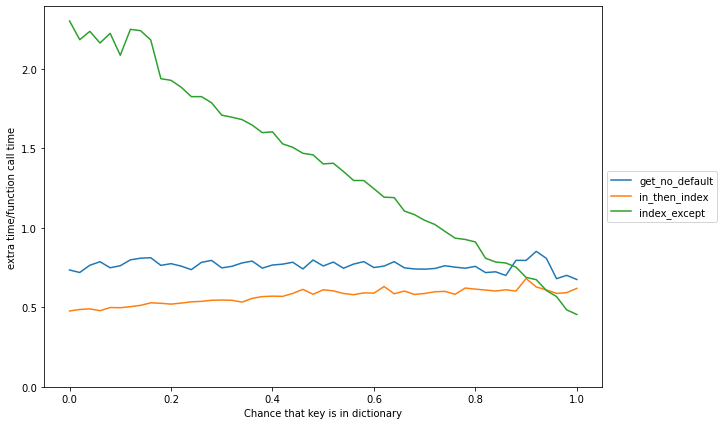

In [209]:
plot_ratios(minratios, ['get_no_default', 'in_then_index', 'index_except'])

We see that in this more realistic test, the results are qualitatively the same. `get` is never the best option and `in` followed by indexing is the best for almost all cases, except when we are very sure that the key will be in the index (again it starts winning aroung 90%).

# What is going on here?


We are also now ready to understand why this is the case. The first thing to understand is that Python handles dictionaries with string indexes through dedicated code. Another thing to understand is that it takes quite a bit of time for Python to look up the name of `.get` in the dictionary's namespace.

In [213]:
minratios.index.levels[1]

Index(['function_call_pass', 'get_cached', 'get_name_lookup', 'get_no_default',
       'hash_only', 'if_only', 'in_only', 'in_then_index', 'index_except',
       'iterate_pass', 'raise_except'],
      dtype='object', name='method')

In the following plot, `get_name_lookup` is the time to do `get = dictionary.get`, while `get_cached` does `get = dictionary.get` outside the lookup loop and uses `value = get(key)` inside the loop. This name lookup effect explains part of the reason why `in` is faster. I've also added the time it takes to do `key in dictionary` as `in_only`. This shows that the name lookup is approximately the same as looking up a value in a dictionary, which is expected since object names are stored in dictionaries. Lastly, I've added the time it takes to call `hash(key)`.

<AxesSubplot:xlabel='Chance that key is in dictionary', ylabel='extra time/function call time'>

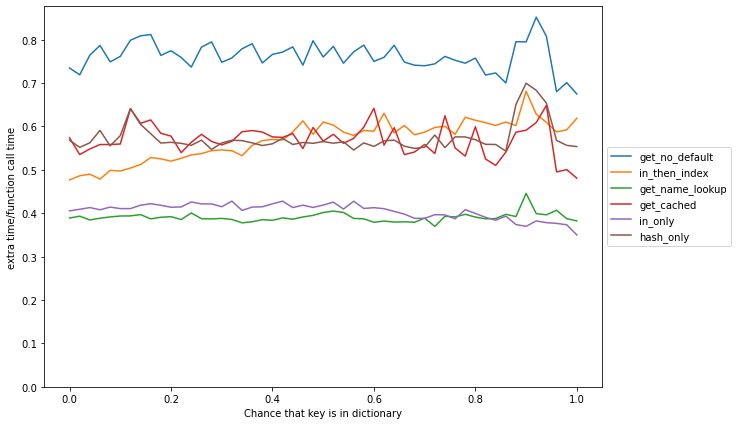

In [218]:
plot_ratios(minratios, ['get_no_default', 'in_then_index', 'get_name_lookup', 'get_cached', 'in_only', 'hash_only'])

A fascinating observation here is that it takes less time to do `key in dictionary` than it does to do `hash(key)`. How can this be? The answer is that the string dictionary code calls hash on the C side. You can clearly see the effect of doing this hashing twice - the graph moves up and to the right, but the cost is much less than you'd imagine because `key in dictionary` and `dictionary[key]` both have dedicated bytecodes, so the Python interpreter doesn't pay the price of calling a Python function twice. This unpacks most of the mystery here.

My final conclusions in the larger case are unchanged from the toy case:

1. If you are using string or int keys, it's always faster to do `in` followed by indexing than to do `.get()`
2. The only exception to this rule is if you are almost certain that the key will be in the dictionary, in which case, indexing and handling the exception is (marginally) faster.
3. `.get()` is better if you are using custom objects which don't benefit from the fast paths in Python for hashing and lookup.

I couldn't find any size of dictionary with string keys where `.get()` did better.